# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make conclusions) then **text answer** is **mandatory** and **is** part of the task
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model is parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

##### Put your markdown formulas here below:

$$ \nabla (\gamma \|w\|_1 + \beta \|w\|_2^2) = \gamma \, \text{sgn} (w) + 2\beta\ w
$$

$$\biggr[\nabla \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0)))\biggr]_j
= \frac{1}{N} \sum_{i=1}^N \frac{\partial}{\partial w_j} \ln(1+\exp(-y_i(w^\top x_i+w_0)))
= \frac{1}{N} \sum_{i=1}^N \frac{- \frac{\partial}{\partial w_j} y_i(w^\top x_i+w_0)} {\exp(y_i(w^\top x_i+w_0)) + 1}
= \frac{1}{N} \sum_{i=1}^N \frac{- y_i X_{i j}} {\exp(y_i(w^\top x_i+w_0)) + 1}
$$


$$ \biggr(
\ln'(1 + e^{-f(x)}) = \frac{(e^{-f(x)})'}{1 + e^{-f(x)}} 
= \frac{-e^{-f(x)}f'(x)}{1 + e^{-f(x)}} 
= \frac{-f'(x)}{1 + e^{f(x)}}
\biggr)$$

$$\biggr[\nabla L(w, w_0)\biggr]_j = \gamma \, \text{sgn} (w_j) + 2\beta\ w_j 
- \frac{1}{N} \sum_{i=1}^N \frac{ y_i x_{i j}} {\exp(y_i(w^\top x_i+w_0)) + 1}
$$

**Reminder!**
Do not use loops in task 2 and task 3. Loss and grad functions should be implemented in matrix form, without loops.

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    
    """
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    """
    return np.mean(np.log(1 + np.exp( - y * (X @ w + w0)) )) + np.sum(gamma * np.abs(w) + beta * np.square(w))

#### 3. [0.5 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    '''

    n, m = X.shape
    
    def stack(arr, reps):
        return np.tile(arr.reshape(-1,1), (1, reps))
    
    p = (X @ w) + w0

    M = stack(p, m)
    Y = stack(y, m)
    
    grad_w = (- Y * X / (1 + np.exp(Y * M))).mean(axis=0)
    
    grad_w0 = (-y / (1 + np.exp(y * p))).mean()
    
    return grad_w + np.sign(w) * gamma + 2 * w * beta, grad_w0

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2))
assert(np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve
from collections import Counter

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr='optimal', tolerance=1e-4, max_iter=1000, random_state=42, pos_label=1):  
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        
        '''
        self.beta = beta        
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.pos_label=pos_label
        
        # There is a theoretical dependancy between eta and total penalty coeff (gamma+beta) for minimizing the loss function
        # I made this so that I don't have to tune eta in part 3 :)
        # optimal learning rate (idea from:
        # https://github.com/scikit-learn/scikit-learn/blob/bac89c253b35a8f1a3827389fbee0f5bebcbc985/sklearn/linear_model/sgd_fast.pyx
        # )
        if lr == 'optimal':
            # total penalty coeff
            self.alpha = max(0.0001, beta + gamma)
            
            typw = np.sqrt(1.0 / np.sqrt(self.alpha))
            
            # derivative of prediction p with respect to the true label y: dloss(p=-typw, y=1.0)
            # dloss for this model = -y / exp(y * p)
            dloss = -1.0 / (np.exp(-typw * 1.0) + 1.0)
            
            # eta0, the initial learning rate
            initial_eta0 = typw / max(1.0, dloss)
            
            # initialize t such that eta at first sample equals eta0
            self.optimal_init = 1.0 / (initial_eta0 * self.alpha)
        
        self.lr = lr
            
        self.random_state = random_state
  
        # you may additional properties if you wish
    
    def calc_loss(self, X, y):
        return loss(X, y, self.w, self.w0, self.gamma, self.beta)
    
    def calc_gradient(self, X, y):
        return get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
        
    def fit(self, X, y):
        
        iterations = 0
        
        self.w = np.zeros(X.shape[1])
        self.w0 = 0
        
        prev = np.full(self.w.shape, -1)
        
        self.loss_history = [self.calc_loss(X, y)]
        
        eta = self.lr
        
        while iterations < self.max_iter:

            grad_w, grad_w0 = self.calc_gradient(X, y)

            if self.lr == 'optimal':
                eta = 1.0 / (self.alpha * (self.optimal_init + iterations))

            if not np.all(np.isfinite(np.r_[self.w - eta*grad_w, self.w0 - eta*grad_w0])):
                return self

            self.w -= eta * grad_w
            self.w0 -= eta * grad_w0

            self.loss_history.append(self.calc_loss(X, y))
            
            if np.linalg.norm(self.w - prev) < self.tolerance:
                break

            iterations += 1

            prev = np.copy(self.w)
        
        return self
    
    def get_loss_steps(self):
        return self.loss_history
    
    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X
        
        '''
        return np.array(2*np.rint(self.decision_function(X))-1, dtype=int)
            
    def decision_function(self, X):
        '''
        Function that estimates probabilities 

        '''
        ans = 1 / (np.exp(-self.w0 - (X @ self.w)) + 1)
        # grid search likes to throw exceptions 
        # if the gradient descent doesnt converge
        ans[~np.isfinite(ans)] = 0.5
        return ans         
    
    def predict_proba(self, X):
        '''
        Function that estimates probabilities 

        '''
        ans = 1 / (np.exp(-self.w0 - (X @ self.w)) + 1)
        # grid search likes to throw exceptions 
        # if the gradient descent doesnt converge
        ans[~np.isfinite(ans)] = 0.5
        return np.column_stack([1-ans, ans])

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

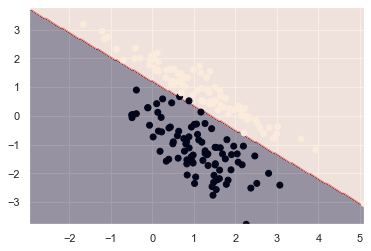

In [9]:
model = Logit(0,0,max_iter=1000)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

Notice that this model has trained more in less iterations because the learning rate is adjusted to be optimal

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

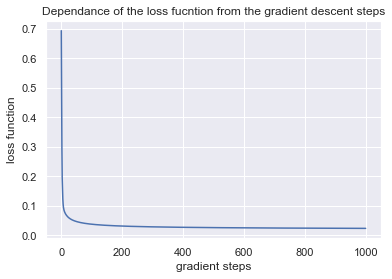

In [10]:
steps = model.get_loss_steps()
plt.title('Dependance of the loss fucntion from the gradient descent steps')
plt.xlabel('gradient steps')
plt.ylabel('loss function')
plt.plot(steps)

And the loss function converges to 0 way quicker, we don't need 1000 iterations to get good results now.

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

### kernel = Linear

In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

clsf = SVC(kernel='linear')

def plot_test(param, rng, log=True, cat=False, ax=None, roc_only=False):
    
    if ax is None:
        _, ax = plt.subplots()
    
    global clsf, X, y
    
    acc = []
    roc = []
    f1 = []
    
    for val in rng:
        clsf.set_params(**{param: val})
        if not roc_only:
            acc.append(cross_val_score(clsf, X, y, scoring='accuracy'))
            f1.append(cross_val_score(clsf, X, y, scoring='f1'))
        roc.append(cross_val_score(clsf, X, y, scoring='roc_auc'))
    
    roc = np.mean(roc, axis=1)
    
    if not roc_only:
        acc = np.mean(acc, axis=1)
        f1 = np.mean(f1, axis=1)
    
    def g1(x1,x2,x3):
        ax.plot(x1,x2,label=x3)
    
    def g2(x1,x2,x3):
        ax.plot(x2)
        ax.scatter(np.arange(len(x2)), x2,label=x3)
    
    pltf = g1
    
    if cat:
        ax.set_xticks(np.arange(len(rng)))
        ax.set_xticklabels(map(str, rng))
        pltf = g2
        
    elif log:
        ax.set_xscale('log')
        
    if not roc_only:
        ax.set_title(f"{param} vs. different metrics")
    else:
        ax.set_title(f"{param} vs. roc_auc")
    
    def get_max(arr, score):
        val = arr[score.argmax()]
        if isinstance(val, (np.floating, float)):
            return '{0:.2f}'.format(val)
        return str(val)
    
    if not roc_only:
        pltf(rng, acc, f'accuracy score  best: {get_max(rng, acc)}')
        pltf(rng, f1,  f'f1 score        best: {get_max(rng, f1)}')
        
    pltf(rng, roc, f'roc-auc score   best: {get_max(rng, roc)}')
    ax.legend(loc='best', prop={'family': 'DejaVu Sans Mono'})
    
def show_plots_list(size, scale, lst, roc_only=False):
    global clsf
    params = clsf.get_params()
    assert np.product(size) >= len(lst)
    fig, axes = plt.subplots(nrows=size[0], ncols=size[1], figsize=(scale[0]*size[0], scale[1]*size[1]))
    for ax, par in zip(np.ravel(axes), lst):
        plot_test(ax=ax, roc_only=roc_only, **par)
        clsf.set_params(**params)
    plt.show()

Let's plot all the hyperparameters alvaliable for this kernel for binary classification

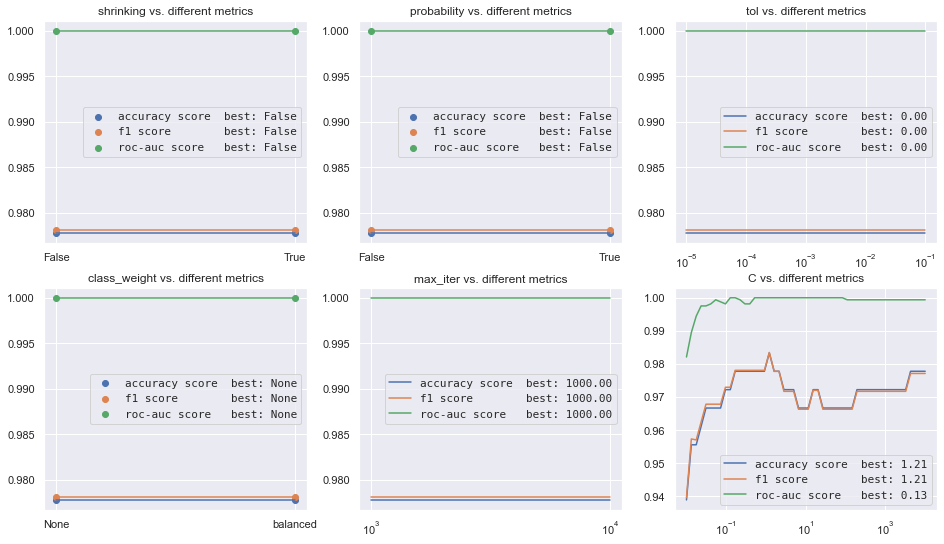

In [12]:
show_plots_list(size=(2, 3), scale=(8, 3), lst=[
    {'param': 'shrinking', 'rng': [False, True], 'cat': True},
    {'param': 'probability', 'rng': [False, True], 'cat': True},
    {'param': 'tol', 'rng': np.logspace(-5,-1, 20), 'log': True},
    {'param': 'class_weight', 'rng': [None, 'balanced'], 'cat': True},
    {'param': 'max_iter', 'rng': np.logspace(3, 4, 20), 'log': True},
    {'param': 'C', 'rng': np.logspace(-2, 4, 50), 'log': True}
])

Only C has significant effect on the metrics for the linear model on this dataset, the optimal value is around 1 for f1 and accuracy, and around 0 for roc-auc score

Overall, this kernel is not too sensitive to hyperparameters

## kernel = RBF

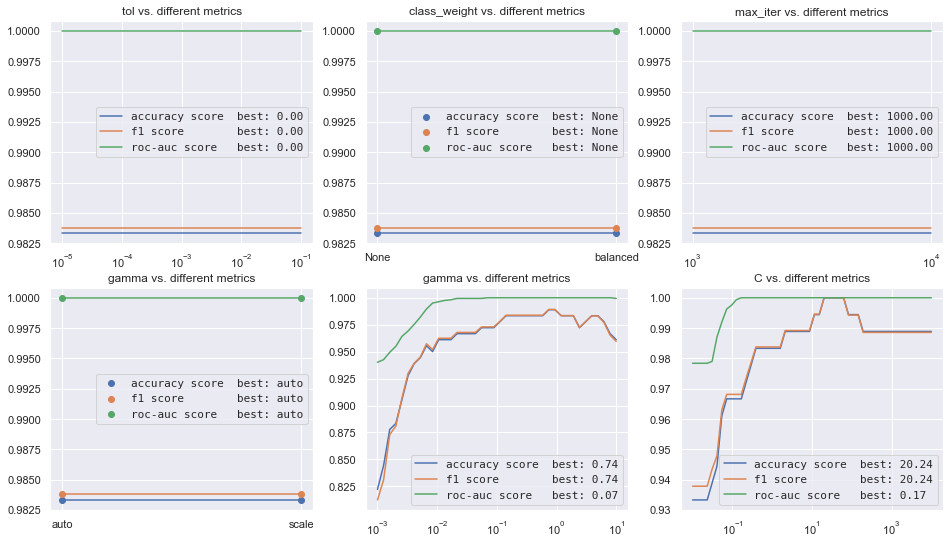

In [13]:
clsf = SVC(kernel='rbf')

show_plots_list(size=(2, 3), scale=(8, 3), lst=[
    {'param': 'tol', 'rng': np.logspace(-5,-1, 20), 'log': True},
    {'param': 'class_weight', 'rng': [None, 'balanced'], 'cat': True},
    {'param': 'max_iter', 'rng': np.logspace(3, 4, 20), 'log': True},
    {'param': 'gamma', 'rng': ['auto', 'scale'], 'cat': True},
    {'param': 'gamma', 'rng': np.logspace(-3, 1, 40), 'log': True},
    {'param': 'C', 'rng': np.logspace(-2, 4, 50), 'log': True}
])

Gamma and C now have a significant effect, the best value for C is now around 20. Gamma has a big effect on the metrics,
although the score is the same if you use default parameters 'auto' and 'scale'. The best value is around 0.5

Overall, a little more sensitive to hyperprarams than Linear

### kernel = Polynomial

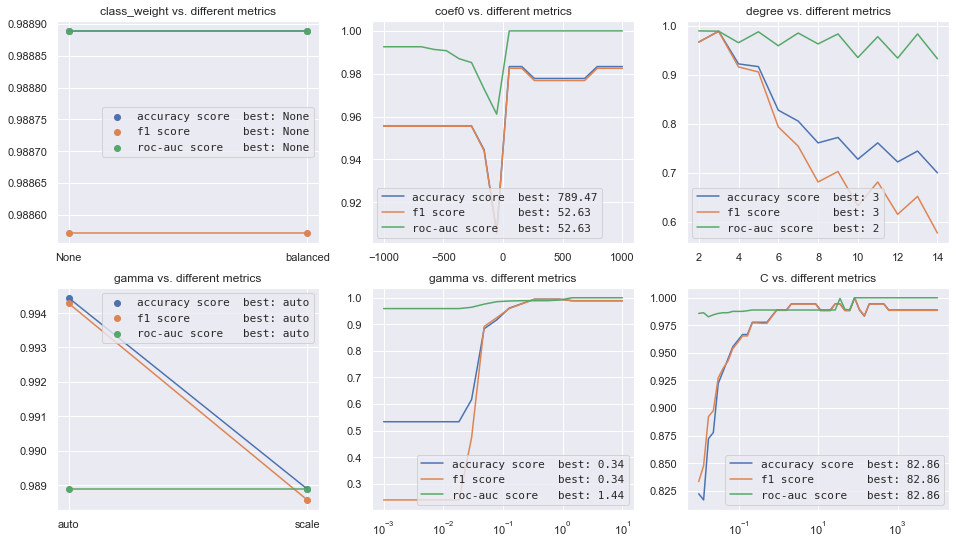

In [14]:
clsf = SVC(kernel='poly')

show_plots_list(size=(2, 3), scale=(8, 3), lst=[
    {'param': 'class_weight', 'rng': [None, 'balanced'], 'cat': True},
    {'param': 'coef0', 'rng': np.linspace(-1000,1000,20), 'log': False},
    {'param': 'degree', 'rng': np.arange(2, 15), 'log': False},
    {'param': 'gamma', 'rng': ['auto', 'scale'], 'cat': True},
    {'param': 'gamma', 'rng': np.logspace(-3, 1, 20), 'log': True},
    {'param': 'C', 'rng': np.logspace(-2, 4, 50), 'log': True}
])

For poly, 4 parameters are significant: degree, coef0, gamma and C

Increasing degree makes accuracy and f1 drop, the best value is 3 (and default)

Very small values of gamma make f1 and accuracy drop, roc-auc stays the same, the best value is around 1

Changing the method for choosing gamma ('auto' or 'scale') now changes the quality a bit, 'auto' gives better accuracy and f1

Small values of C also make f1 and roc-auc drop, best value is around 83

Negative values of coef0 makes all metrics dropm best value is 53

Other params have no effect once again

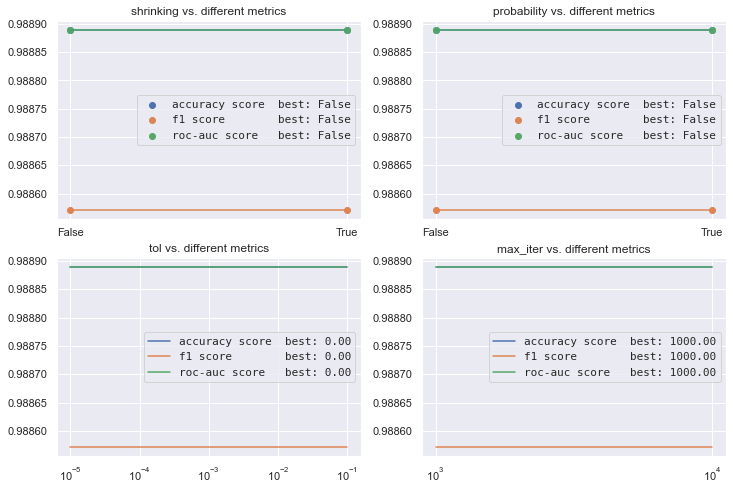

In [15]:
show_plots_list(size=(2, 2), scale=(6,4), lst=[
    {'param': 'shrinking', 'rng': [False, True], 'cat': True},
    {'param': 'probability', 'rng': [False, True], 'cat': True},
    {'param': 'tol', 'rng': np.logspace(-5,-1, 20), 'log': True},
    {'param': 'max_iter', 'rng': np.logspace(3, 4, 20), 'log': True}
])

Overall, The Polynomial kernel is very sensitive to hyperparameters

## Conclusion:

The Linear kernel is the least prone to overfitting, the most significant parameter was C (regularization coeff) and it only affected the metrics slightly

The RBF kernel is the second one: gamma affected these metrics the most with f1 and accuracy dropping to 0.83 for small values. C showed similar results to linear

The Polynomial kernel was the most prone to overfitting, with F1 scores dropping to less than 0.3 when gamma was low enough,
C also affected it more, dropping to 0.83 with values close to 0. Degree also had a big effect, f1 and accuracy were steadily decreasing from 0.99 to 0.6 with higer and higher degrees.

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section


I chose these authors:

- Tolstoy      

- Gorky        

- Bryusov      

- Chekhov      

- Pushkin       

- Lermontov     


### Building the dataset

1. Build your own dataset for these authors: [0.5 point]
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     

In [16]:
# Custom list because the oringinal one is not complete.
stop_words = ['а', 'без', 'более', 'больше', 'будет', 'будто', 'бы', 'был', 'была', 'были', 'было', 'быть', 'в', 'вам', 'вас', 'ваша', 'вдруг', 'ведь', 'во', 'вообще', 'вот', 'впрочем', 'вроде', 'все', 'всегда', 'всего', 'всем', 'всех', 'всю', 'вся', 'всё', 'вы', 'где', 'да', 'давай', 'даже', 'два', 'для', 'до', 'другой', 'его', 'ее', 'ей', 'ему', 'если', 'есть', 'еще', 'ещё', 'ж', 'же', 'за', 'зачем', 'здесь', 'и', 'из', 'или', 'им', 'иногда', 'их', 'к', 'кажется', 'как', 'как-то', 'какая', 'какие', 'какой', 'когда', 'конечно', 'который', 'кстати', 'кто', 'кто-то', 'куда', 'ли', 'либо', 'лучше', 'между', 'меня', 'мне', 'много', 'может', 'можно', 'мой', 'моя', 'мы', 'на', 'над', 'надо', 'наконец', 'нам', 'например', 'нас', 'наше', 'не', 'него', 'нее', 'ней', 'нельзя', 'нет', 'ни', 'нибудь', 'никогда', 'ним', 'них', 'ничего', 'но', 'ну', 'о', 'об', 'один', 'он', 'она', 'они', 'оно', 'опять', 'от', 'очень', 'перед', 'по', 'под', 'после', 'потом', 'потому', 'почти', 'при', 'про', 'просто', 'прям', 'раз', 'разве', 'с', 'сам', 'самые', 'своем', 'свои', 'свой', 'свою', 'себе', 'себя', 'сейчас', 'со', 'совсем', 'так', 'такое', 'такой', 'там', 'твоем', 'твой', 'тебе', 'тебя', 'тем', 'теперь', 'то', 'тогда', 'того', 'тоже', 'только', 'том', 'тот', 'три', 'туда', 'тут', 'ты', 'у', 'уж', 'уже', 'хорошо', 'хоть', 'хотя', 'чего', 'чем', 'через', 'что', 'что-то', 'чтоб', 'чтобы', 'чуть', 'эта', 'эти', 'это', 'этого', 'этой', 'этом', 'этот', 'эту', 'я']
stop_words = set(stop_words)

In [17]:
import os  
import re
from nltk import tokenize
from nltk import WordPunctTokenizer
import nltk

X, y = [], []

word_tokenizer = WordPunctTokenizer()

for i, (dirname, _, filenames) in enumerate(os.walk('.\prose')):

    author = dirname.split('\\')[-1]
    
    sentences = []
    
    for filename in filenames:
        
        if filename.split('.')[-1] != 'txt':
            continue
            
        uri = os.path.join(dirname, filename)
              
        with open(uri, encoding='utf-8') as file:
            lines = file.read().replace('\n', '. ')
            
            # Replace punctuation
            for punct in  ['...'] + list('—…;!?'):
                lines = lines.replace(punct, '.')
                
            # Tokenize sentences
            tokens = tokenize.sent_tokenize(lines)
            
            # Find and filter out words
            tokens = [filter(lambda x: x.lower() not in stop_words, word_tokenizer.tokenize(token)) for token in tokens]
            
            # Make sure we got rid of all punctuation
            tokens = [' '.join(filter(lambda word: re.search('[ЁёА-я]+', word), sent)) for sent in tokens]
            
            # Filter out short sentences
            file_sentences = list(filter(lambda x: len(x) >= 15, tokens))
            
            sentences.extend(file_sentences)
    X.append(sentences)
    y.append([author] * len(sentences))
    
X = np.hstack(X)
y = np.hstack(y)

print(X.shape, y.shape)

(353876,) (353876,)


In [18]:
data = pd.DataFrame({'sentence':X, 'author':y})
data.head()

,sentence,author
0,Болото вымостили булыжником,Blok
1,Среди булыжника поставили каменные ящики перег...,Blok
2,Каждый маленький ящик оклеили бумагой,Blok
3,ящик положили стол стул кровать умывальник Ива...,Blok
4,Ивана Ивановича жены вместе меньше бессмертной...,Blok


In [19]:
vc = data.author.value_counts()
vc

Dostoevsky    106222
Tolstoy        80764
Gorky          46873
Bryusov        23074
Turgenev       22865
Gogol          22315
Chekhov        21205
Herzen         15709
Pushkin        10151
Lermontov       4332
Blok             366
Name: author, dtype: int64

### Choosing authors

In [20]:
proportions = np.array(sorted(map(int,'30k : 15k : 7k : 20k : 40k : 3'.split('k : ')))[::-1])
y_true = np.array(proportions) / max(proportions)
proportions, y_true

(array([40, 30, 20, 15,  7,  3]),
 array([1.   , 0.75 , 0.5  , 0.375, 0.175, 0.075]))

In [21]:
from itertools import combinations
min_loss, min_names, min_amounts = float('inf'), [], []

# Let's find the best fit so that we lose the least amount of data
vc = data.author.value_counts()

# Iterate over all subsets of size 6.
for i in combinations(vc.items(), 6):
    
    # Get names and value counts
    names, counts = zip(*i)
    counts = np.array(counts)
    
    # Find the biggest data loss
    min_arg = np.argmin(counts / y_true)
    
    # The biggest amounts of sents for each author we can retain without changing the ratio
    amounts = np.array(np.rint(y_true * counts[min_arg] / y_true[min_arg]), dtype=int)
    
    # Loss is based on how much % of data was lost for each author 
    Loss = np.abs(counts / amounts - 1).sum()
    
    # Find a set of authors with min loss
    if Loss < min_loss:
        min_loss = Loss
        min_names = names
        min_amounts = amounts

vc = vc[vc.index.isin(min_names)] 
print(f'data loss = {(1 - min_amounts.sum() / vc.sum())*100:.2f}%')
min_names, min_amounts

data loss = 28.82%


(('Tolstoy', 'Gorky', 'Bryusov', 'Chekhov', 'Pushkin', 'Lermontov'),
 array([46148, 34611, 23074, 17306,  8076,  3461]))

In [22]:
vc = vc[vc.index.isin(min_names)]
vc

Tolstoy      80764
Gorky        46873
Bryusov      23074
Chekhov      21205
Pushkin      10151
Lermontov     4332
Name: author, dtype: int64

In [23]:
for name, curr_amount, new_amount in zip(min_names, list(vc), min_amounts):
    idx = data[data.author==name].sample(n=curr_amount-new_amount, random_state=123).index
    data.drop(idx, inplace=True)
    
for name, _ in data.author.value_counts().items():
    if name not in min_names:
        data.drop(data[data.author==name].index, inplace=True)
        
# We'll use imblearn to reduce / increase the size of the dataset.
data.author.value_counts()

Tolstoy      46148
Gorky        34611
Bryusov      23074
Chekhov      17306
Pushkin       8076
Lermontov     3461
Name: author, dtype: int64

## Preprocessing

2. Preprocess (tokenize and clean) the dataset  [1.5 point]
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [24]:
import pymorphy2
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

lemmatizer = pymorphy2.MorphAnalyzer()

def process(text):
    
    # Already removed everything 
    tokens = text.lower().split()
    
    # Lemmatize
    tokens = [lemmatizer.parse(word)[0].normal_form for word in tokens]
    
    # Check again if lemmatized form is in stop_words
    tokens = ' '.join(filter(lambda word: word not in stop_words, tokens))
    
    return tokens

try:
    # print(1//0) # reload (yes im doing it this way xd)
    lem_data = pd.read_pickle("./lemmatized-data.pkl")
except:
    lem_data = pd.DataFrame({'sentence': data.sentence.progress_apply(process), 'author': data.author})
    lem_data.to_pickle("./lemmatized-data.pkl")

In [25]:
lem_data.author.value_counts()

Tolstoy      46148
Gorky        34611
Bryusov      23074
Chekhov      17306
Pushkin       8076
Lermontov     3461
Name: author, dtype: int64

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 50)
vectorizer.fit(lem_data.sentence)
X_cv = vectorizer.transform(lem_data.sentence)

# top 10 words
vectorizer.get_feature_names_out()[:10]

array(['бог', 'весь', 'взять', 'видеть', 'время', 'глаз', 'говорить',
       'год', 'голова', 'голос'], dtype=object)

In [27]:
X_cv.todense()[:5]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

idf_vectorizer = TfidfVectorizer(max_features=50)
idf_vectorizer.fit(lem_data.sentence)
X_idf = idf_vectorizer.transform(lem_data.sentence)

In [29]:
X_idf=X_idf.todense()
X_idf[:2]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.69175329, 0.        , 0.        , 0.        ,
         0.        , 0.        , 

The numbers from bag of words (Count Vectorizer) are all integer, whlie numbers from TF-IDF are floating-point

They represent the amount of words that match with the 50 most common words for CountVectorizer

and for TF-IDF it's the same number multiplied by the importance of each word, i.e. tf * idf

here tf = term frequency; idf = inverse document frequency

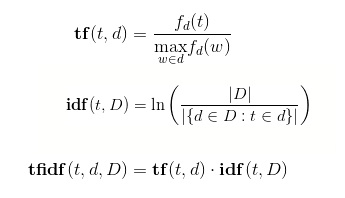

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. [1 point]
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. [1 point]
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

**HINT:** In the task 8.2 you should analyze models for binary classification task. How do you think the AUC_ROC should be high? Is the 0.6 enough for us?

_We'll pick Pushkin and Lermontov since they have the least amount of sents_

In [35]:
bin_classification_authors = ['Lermontov', 'Pushkin']

I_raw = np.isin(lem_data.author, bin_classification_authors)
X_raw = lem_data.sentence[I_raw].to_numpy()
y_raw = lem_data.author[I_raw].replace({'Pushkin':1, 'Lermontov':-1}).to_numpy()

from collections import Counter
Counter(y_raw)

Counter({-1: 3461, 1: 8076})

The balance is about 3 : 7 

### Vectorize again and find best params

Fix the imbalance by oversampling:

In [36]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE 

vectorizer = TfidfVectorizer(ngram_range=(1,3))
X_num = vectorizer.fit_transform(X_raw)

smote = SMOTE(random_state=23423)
X_num, y_raw = smote.fit_resample(X_num, y_raw)

# Inverse transform is here because we will search for the best # of dimensions later
X_raw = vectorizer.inverse_transform(X_num)

# You can improve this of course (it's hard with just numpy) but this is not that slow anyway
for i, sent in enumerate(X_raw):
    # Ignore ngrams of size >1
    X_raw[i] = ' '.join([word for word in sent if ' ' not in word])
    
X_raw = np.array(X_raw)
X_raw.shape, y_raw.shape

((16152,), (16152,))


This custom transformer vectorizes, selects the best featrues, reduces the dimensions and std rescales the data

this is in a way a Neural Network (right?) which is kind of cool 

In [37]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.base import TransformerMixin, BaseEstimator
from imblearn.pipeline import Pipeline

# probably not the best way to do this but i think this works 
class CustomTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer.
    n_features - the top n features that are used as data
    n_components - the amount of data features that are left after dimension lowering
    """
    def __init__(self, n_features=500, n_components_factor=10, random_state=3423):
        self.random_state = random_state
        self.n_features = n_features
        self.n_components_factor = n_components_factor
        
    def fit(self, X, y):    
        n_componenets = int(self.n_features / self.n_components_factor)
        
        # Get vectorized data with all features in it
        vectorizer = TfidfVectorizer(ngram_range=(1,3))
        X_res = vectorizer.fit_transform(X)
        
        # Select the best features by chi2 score
        # This means the features with the most divergent freqencies for this particular class
        # as compared to other classes will be selected
        selector = GenericUnivariateSelect(chi2, mode='k_best', param=self.n_features)
        selector.fit(X_res, y)
        
        features = vectorizer.get_feature_names_out()
        self.vocabulary_ = selector.get_feature_names_out(features)
        
        # Construct a vectorizer pipeline that uses all the selected features
        self.vectorizer_ = Pipeline([
            ('tf_idf', TfidfVectorizer(ngram_range=(1,3), vocabulary=self.vocabulary_)),
            ('truncated_svd', TruncatedSVD(n_components=n_componenets, random_state=self.random_state)),
            ('std_scaler', StandardScaler())
        ])    
        
        return self    
    
    # This function will only be used in a fit transform statement anyway
    def transform(self, X, y=None):
        return self.vectorizer_.fit_transform(X)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    
    def get_vectorizer(self):
        return self.vectorizer_
    
    def get_vocabulary(self):
        return self.vocabulary_

Grid search for the best dimensions

In [38]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'vect__n_features': [200, 500, 1000, 2000],
    'vect__n_components_factor': [5, 10, 20, 100],
}

dimension_search = GridSearchCV(
    verbose=10,
    estimator= Pipeline([
                ('vect', CustomTransformer()),
                ('svc', SVC(probability=True))
            ]),
    scoring='roc_auc', 
    param_grid=parameters,
    n_jobs=-1,
)

dimension_search.fit(X_raw, y_raw)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CustomTransformer()),
                                       ('svc', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'vect__n_components_factor': [5, 10, 20, 100],
                         'vect__n_features': [200, 500, 1000, 2000]},
             scoring='roc_auc', verbose=10)

In [39]:
print(dimension_search.best_params_)
print(dimension_search.best_score_)

{'vect__n_components_factor': 20, 'vect__n_features': 1000}
0.5342973692609319


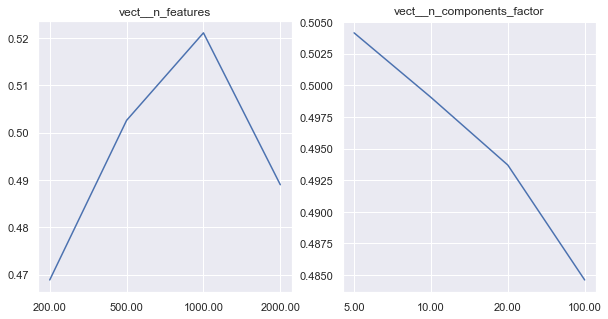

In [40]:
# We'll use this later as well
def plot_mean_scores(results, params, figsize=(10, 5), ncols=2, nrows=1):
    tests = results['params']
    scores = results['mean_test_score']
    ans = []
    for parameter in params:
        parameter = parameter
        m_scores = {}
        for i, test in enumerate(tests):
            val = test[parameter]
            if val in m_scores:
                m_scores[val].append(scores[i])
            else:
                m_scores[val] = [scores[i]]
        ans.append((list(m_scores.keys()), list(map(np.mean, m_scores.values()))))

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)

    for ax, vals, title in zip(axs, ans, params):
        ax.set_title(title)
        ax.set_xticklabels(labels=list(map(lambda x: f"{x:.2f}" if type(x) != str else x, vals[0])))
        ax.set_xticks(ticks=np.arange(len(vals[1])))
        ax.plot(np.arange(len(vals[1])), vals[1])
        
    plt.show()
    
plot_mean_scores(dimension_search.cv_results_, ['vect__n_features', 'vect__n_components_factor'])

n = 1000 seems to be the best amount of features; reducing the dimensiality makes the result linearly worse

### Training the models 

Rebuilding the dataset since we now have a new vectorizer => new features => SMOTE algorithm  inputs changed

In [43]:
I_raw = np.isin(lem_data.author, bin_classification_authors)
X_raw = lem_data.sentence[I_raw].to_numpy()
y_raw = lem_data.author[I_raw].replace({'Pushkin':1, 'Lermontov':-1}).to_numpy()

best_transform = dimension_search.best_estimator_.named_steps['vect'].get_vectorizer()
X = best_transform.fit_transform(X_raw, y_raw)

smote = SMOTE(random_state=23423)
X, y = smote.fit_resample(X, y_raw)

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=142)

logit = Logit(0,0, max_iter=500)

svc = SVC()

In [46]:
logit.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_train_pred_log = logit.predict(X_train)
y_train_pred_svc = svc.predict(X_train)

y_test_pred_log = logit.predict(X_test)
y_test_pred_svc = svc.predict(X_test)

### Confusion Matrix

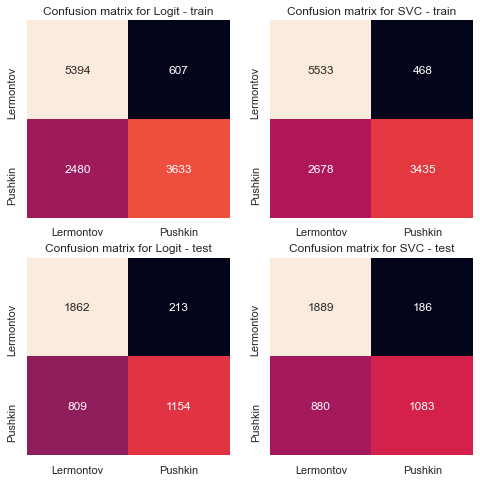

In [47]:
lst = [
    (y_train, y_train_pred_log, 'Logit - train'),
    (y_train, y_train_pred_svc, 'SVC - train'),
    (y_test, y_test_pred_log, 'Logit - test'),
    (y_test, y_test_pred_svc, 'SVC - test'),
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for ax, (y_real, y_pred, label) in zip(np.ravel(axes), lst):
    labels = bin_classification_authors
    sns.heatmap(ax=ax, data=confusion_matrix(y_real, y_pred),
                annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    ax.set_title(f"Confusion matrix for {label}")
plt.show()

In [49]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

for clsf, name in zip([svc, logit], ['SVC', 'Logit']):
    print(f'Cross validation results for {name}:')
    metrics = cross_validate(clsf, X, y, scoring=[
        'accuracy',
        'recall',
        'precision',
        'f1',
        'roc_auc'
    ]) 
    for k in metrics.keys():
        if k.startswith('test_'):
            print(f"{k.lstrip('test_')} score: {metrics[k].mean()}")
    print()

Cross validation results for SVC:
accuracy score: 0.7209001229382922
recall score: 0.5238887441375717
precision score: 0.8640747479304769
f1 score: 0.6491520183579059
roc_auc score: 0.8112366213878431

Cross validation results for Logit:
accuracy score: 0.7285781031857596
recall score: 0.554595990558808
precision score: 0.848198596824109
f1 score: 0.6676839776449885
roc_auc score: 0.8021141363398291



Conclusion:

It seems like our efforts have paid off and the roc_auc score is much better than 0.6 that was stated in this task. 

A roc-auc of 0.8 seems like a really good score for this dataset. Surley, this is high enough.

Accuracy is pretty high, while recall could be improved by adjusting the threshold for predictions.

### Hyperparameter tuning (again)

In [787]:
from sklearn.model_selection import GridSearchCV

In [789]:
parameters = {
    'gamma': list(np.logspace(-3, 1, 5)) + ['auto', 'scale'],
    'C': np.logspace(-1, 3, 5),
}

svc_search = GridSearchCV(
    verbose=10,
    estimator=svc,
    scoring='roc_auc', 
    param_grid=parameters,
    n_jobs=-1
)

svc_search.fit(X, y)

print(svc_search.best_params_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
{'C': 1000.0, 'gamma': 0.1}


In [790]:
svc_search.best_score_

0.8402065937116863

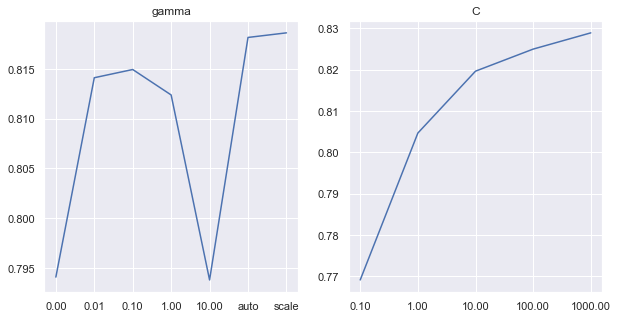

In [822]:
def plot_mean_scores(results, params, figsize=(10, 5), ncols=2, nrows=1):
    tests = results['params']
    scores = results['mean_test_score']
    ans = []
    for parameter in params:
        parameter = parameter
        m_scores = {}
        for i, test in enumerate(tests):
            val = test[parameter]
            if val in m_scores:
                m_scores[val].append(scores[i])
            else:
                m_scores[val] = [scores[i]]
        ans.append((m_scores.keys(), list(map(np.mean, m_scores.values()))))

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)

    if type(axs) != np.ndarray:
        axs = [axs]
    
    for ax, vals, title in zip(axs, ans, params):
        ax.set_title(title)
        ax.set_xticklabels(labels=list(map(lambda x: f"{x:.2f}" if type(x) != str else x, vals[0])))
        ax.set_xticks(ticks=np.arange(len(vals[1])))
        ax.plot(np.arange(len(vals[1])), vals[1])
        
    plt.show()
        
plot_mean_scores(svc_search.cv_results_, ['gamma', 'C'])

In [795]:
parameters = {
    'beta': np.r_[[0], np.logspace(-3, 0, 4)],
    'gamma':  np.r_[[0], np.logspace(-3, 0, 4)],
    'max_iter': [100, 200, 500]
}

log_srch = GridSearchCV(
    verbose=10,
    estimator=logit,
    scoring='roc_auc', 
    param_grid=parameters,
    n_jobs=-1
)

log_srch.fit(X, y)

print(log_srch.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'beta': 0.0, 'gamma': 0.0, 'max_iter': 500}


In [796]:
log_srch.best_score_

0.8021141363398291

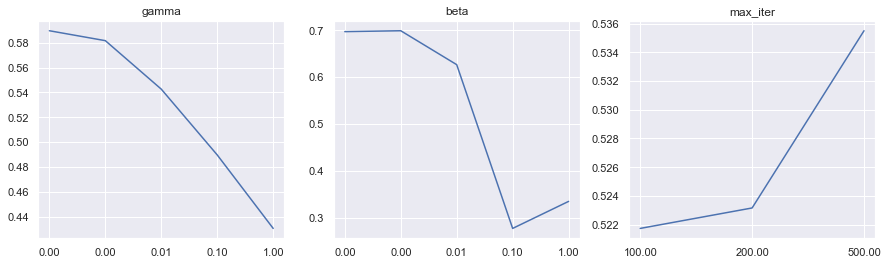

In [810]:
plot_mean_scores(log_srch.cv_results_, ['gamma', 'beta', 'max_iter'], ncols=3, figsize=(15,4))

Conclusion:

For the SVC model, higher values of C seem to give better results, while for gamma the best value was 'scale'



Gamma and beta are only an obstacle for the Logit model, while more iterations increased the quality.
Increasing beta seemed to have a dramatic effect on the quality: it fell significantly.

Let's have another linear search for the best value of max_iter with gamma and beta as low as possible

In [824]:
linear_log_search = GridSearchCV(
    verbose=10,
    estimator=logit,
    scoring='roc_auc', 
    param_grid={
        'max_iter': np.logspace(1, 3, 10)
    },
    n_jobs=-1
)

linear_log_search.fit(X, y)

print(linear_log_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'max_iter': 1000.0}


In [825]:
linear_log_search.best_score_

0.8019956759267546

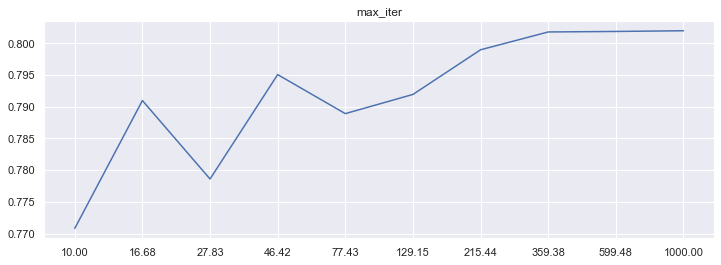

In [827]:
plot_mean_scores(linear_log_search.cv_results_, ['max_iter'], ncols=1, figsize=(12,4))

Seems like the score for our model levels off after about 360 iterations

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

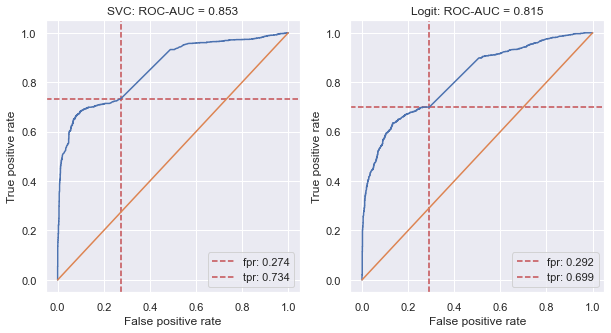

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

logit = Logit(0,0,max_iter=360)
svc = SVC(C=1000, gamma='scale', probability=True)

for ax, clsf in zip(ax, [svc, logit]):
    
    clsf.fit(X_train, y_train)
    y_pred_proba = clsf.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Last index where fpr <= 0.3
    index = np.argwhere(fpr <= 0.3)[-1]
    
    ax.axvline(fpr[index], c='r', ls='--', label=f'fpr: {fpr[index][0]:.3f}')
    ax.axhline(tpr[index], c='r', ls='--', label=f'tpr: {tpr[index][0]:.3f}')
    ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')
    
    ax.set_title(f"{str(clsf).split('(')[0]}: ROC-AUC = {roc_auc_score(y_test, y_pred_proba):.3f}")
    ax.plot(fpr, tpr)
    ax.plot([0,1],[0,1])
    ax.legend(loc='best')

Conclusion: 

With a fpr rate of 0.3 we got tpr rates of about 0.7 and the ROC-AUC score is more than 0.8.

This is an improvement over the previous attempt with tpr around 0.5 for fpr = 0.3 and AUC = 0.64

The ROC curve looks a little strange probably due to the transformations that we made

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score). **HINT:** Do not forget about set jobs=-1 in the GridSearchCV init to speed up calculations.
* make conclusions about the model

In [918]:
X_raw = lem_data.sentence.to_numpy()
y_raw = lem_data.author.to_numpy()
Counter(y_raw)

Counter({'Bryusov': 23074,
         'Chekhov': 17306,
         'Gorky': 34611,
         'Lermontov': 3461,
         'Pushkin': 8076,
         'Tolstoy': 46148})

### Feature selection

In [951]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)

X_num = vectorizer.fit_transform(X_raw)

X_num.shape, y_raw.shape

((132676, 10000), (132676,))

Initial resampling to extract the features:

In [961]:
from imblearn.under_sampling import NearMiss

nm = NearMiss(version=2)

X, y = nm.fit_resample(X_num, y_raw)

Counter(y)

Counter({'Bryusov': 3461,
         'Chekhov': 3461,
         'Gorky': 3461,
         'Lermontov': 3461,
         'Pushkin': 3461,
         'Tolstoy': 3461})

Selecting the features:

In [962]:
selector = GenericUnivariateSelect(chi2, mode='k_best', param=3000)

selector.fit(X, y)

features = vectorizer.get_feature_names_out()

vocab = selector.get_feature_names_out(features)

Inverse transform

In [965]:
X_raw = vectorizer.inverse_transform(X)

for i, sent in enumerate(X_raw):
    X_raw[i] = ' '.join([word for word in sent if ' ' not in word])
    
X_raw = np.array(X_raw)
X_raw.shape, y.shape

((20766,), (20766,))

Now let's resample the data with the new vectorizer

In [966]:
transformer = Pipeline([
    ('tf_idf', TfidfVectorizer(ngram_range=(1,3), vocabulary=vocab)),
    ('truncated_svd', TruncatedSVD(n_components=100, random_state=1651)),
    ('std_scaler', StandardScaler())
]) 

X = transformer.fit_transform(X_raw, y)

Declaring the model

In [967]:
from sklearn.multiclass import OneVsRestClassifier

multi_logit = OneVsRestClassifier(Logit(0,0,max_iter=360))

Splitting the dataset into training and testing parts

In [968]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=213124)

multi_logit.fit(X_train, y_train)

y_pred_train = multi_logit.predict(X_train)
y_pred_test = multi_logit.predict(X_test)

Confusion matrix

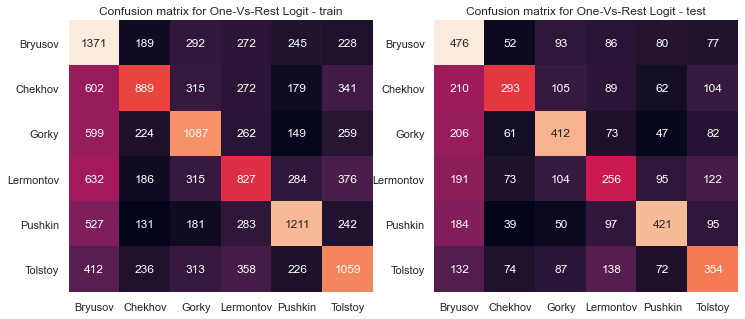

In [969]:
lst = [
    (y_train, y_pred_train, 'One-Vs-Rest Logit - train'),
    (y_test, y_pred_test, 'One-Vs-Rest Logit - test'),
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for ax, (y_real, y_pred, label) in zip(np.ravel(axes), lst):
    labels = multi_logit.classes_
    sns.heatmap(ax=ax, data=confusion_matrix(y_real, y_pred),
                annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    ax.set_title(f"Confusion matrix for {label}")
plt.show()

The confusion matrix looks decent -- the values mostly lie on the main diagonal, but the model has a slight bias for Bryusov -- the threshold for this label might not be adjusted correctly. 

In [970]:
print(f'Cross validation results for Logit:')
metrics = cross_validate(multi_logit, X, y, scoring=[
    'balanced_accuracy',
    'recall_micro',
    'recall_macro',
    'precision_micro',
    'precision_macro',
    'f1_micro',
    'f1_macro',
    'roc_auc_ovr'
]) 
for k in metrics.keys():
    if k.startswith('test_'):
        print(f"{k.lstrip('test_')} score: {metrics[k].mean()}")

Cross validation results for Logit:
balanced_accuracy score: 0.38272325512209904
recall_micro score: 0.38274316261912983
recall_macro score: 0.38272325512209904
precision_micro score: 0.38274316261912983
precision_macro score: 0.3866614260370262
f1_micro score: 0.38274316261912983
f1_macro score: 0.3767196524529246
roc_auc_ovr score: 0.6524036576181076


The quality has dropped copmared to the binary case because the dataset was undersampled instead of oversampled. Other metrics are also worse as it is harder to predict correctly if there's more different options. Not to mention that the quality of this dataset is not the best as there are a lot of short sentences and shared language between these authors. 

Grid search:

In [973]:
parameters = {
    'estimator__beta': np.r_[[0], np.logspace(-3, 0, 4)],
    'estimator__gamma':  np.r_[[0], np.logspace(-3, 0, 4)],
    'estimator__max_iter': [100, 200, 500]
}


multi_log_srch = GridSearchCV(
    verbose=10,
    estimator=OneVsRestClassifier(Logit()),
    scoring='roc_auc_ovr', 
    param_grid=parameters,
    n_jobs=-1
)

multi_log_srch.fit(X, y)
print(multi_log_srch.best_params_)
print(multi_log_srch.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'estimator__beta': 0.1, 'estimator__gamma': 0.0, 'estimator__max_iter': 500}
0.6986190830434589


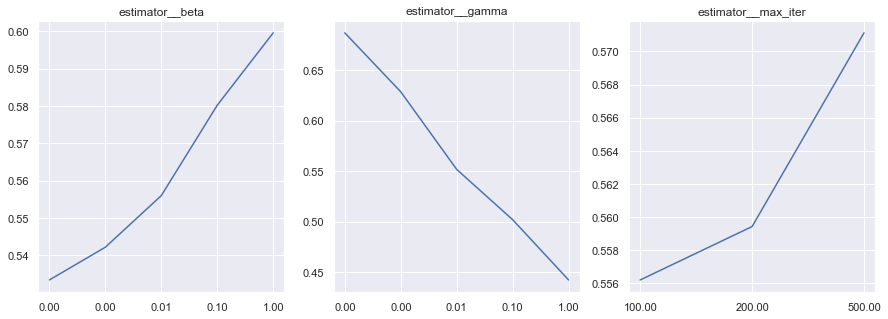

In [980]:
plot_mean_scores(multi_log_srch.cv_results_, ['estimator__beta', 'estimator__gamma', 'estimator__max_iter'], 
                 ncols=3, figsize=(15, 5))

Conclusion:

The results of this grid search indicate that increasing the amount of iterations improves the score, while higher values of gamma make it significantly worse, just like in the binary case. However, unlike the binary case, increasing beta this time improved the score. Hyperparameter tuning increased the roc-auc score to about 0.7 

Overall, the model could be improved but it takes a really long time to train if the dataset is oversampled. It might be better to use more data using the ensable approach instead of oversampling and using multiple models with a voting system for categorization. The time complexity for the estimator grows quadratically with the input so having multiple models will reduce the training time dramatically.